# AMEX EDA which makes sense ⭐️⭐️⭐️⭐️⭐️

This EDA analyzes the data and gives some insight which is useful for designing a machine learning pipeline and selecting a model.

In [1]:
import pandas as pd
import numpy as np
import pickle, gc
from matplotlib import pyplot as plt

# The labels

We start by reading the labels for the training data. There are neither missing values nor duplicated customer_IDs. Of the 458913 customer_IDs, 340000 (74 %) have a label of 0 (good customer, no default) and 119000 (26 %) have a label of 1 (bad customer, default).

We know that the good customers have been subsampled by a factor of 20; this means that in reality there are 6.8 million good customers. 98 % of the customers are good; 2 % are bad.

**Insight:**
- The classes are imbalanced. A StratifiedKFold for cross-validation is recommended.
- Because the classes are imbalanced, accuracy would be a bad metric to evaluate a classifier. The [competition metric](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327464) is a mix of area under the roc curve (auc) and recall.

In [6]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head(2)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [7]:
# Check for missing data and duplicated customer_IDs
train_labels.isna().any().any(), train_labels.customer_ID.duplicated().any()

(False, False)

In [4]:
label_stats = pd.DataFrame({'absolute': train_labels.target.value_counts(),
              'relative': train_labels.target.value_counts() / len(train_labels)})
label_stats['absolute upsampled'] =  label_stats.absolute * np.array([20, 1])
label_stats['relative upsampled'] = label_stats['absolute upsampled'] / label_stats['absolute upsampled'].sum()
label_stats

,absolute,relative,absolute upsampled,relative upsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


# The data

The dataset of this competition has a considerable size. If you read the original csv files, the data barely fits into memory. That's why we read the data from @munumbutt's [AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather). In this [Feather](https://arrow.apache.org/docs/python/feather.html) file, the floating point precision has been reduced from 64 bit to 16 bit. And reading a Feather file is faster than reading a csv file because the Feather file format is binary.

There are 5.5 million rows for training and 11 million rows of test data.

In [5]:
%%time
train = pd.read_feather('../input/amexfeather/train_data.ftr')
test = pd.read_feather('../input/amexfeather/test_data.ftr')
with pd.option_context("display.min_rows", 6):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.981934,0.002474,0.000077,0.992676,0.000809,0.119141,0.003286,0.014091,...,NaN,NaN,0.007317,0.002888,0.006207,NaN,0.005112,0.003183,0.001914,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363759,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-02-17,0.459961,0.005245,0.004421,0.818848,0.000665,NaN,0.000559,0.007057,...,NaN,NaN,NaN,0.007797,0.007740,0.008194,NaN,0.009384,0.003593,0.005604
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460449,0.002663,0.009529,0.816406,0.009026,NaN,0.008530,0.006851,...,NaN,NaN,NaN,0.007195,0.008453,0.004776,NaN,0.006199,0.005604,0.005970
11363761,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.454590,0.004402,0.000346,0.810059,0.008736,NaN,0.000937,0.003494,...,NaN,NaN,NaN,0.003399,0.009590,0.006187,NaN,0.007675,0.006443,0.003143


CPU times: user 30.2 s, sys: 38.5 s, total: 1min 8s
Wall time: 1min 9s


The target column of the train dataframe corresponds to the target column of train_labels.csv. In the csv file of the train data, there is no target column; it has been joined into the Feather file as a convenience.

S_2 is the statement date. All train statement dates are between March of 2017 and March of 2018 (13 months), and no statement dates are missing. All test statement dates are between April of 2018 and October of 2019. This means that the statement dates of train and test don't overlap:

In [6]:
print('Train statement dates: ', train.S_2.min(), train.S_2.max(), train.S_2.isna().any())
print('Test statement dates: ',  test.S_2.min(), test.S_2.max(), test.S_2.isna().any())


Train statement dates:  2017-03-01 00:00:00 2018-03-31 00:00:00 False
Test statement dates:  2018-04-01 00:00:00 2019-10-31 00:00:00 False




**Insight:**
- The test data come from a different phase in the economic cycle than the training data. Our models have no way of learning the effect of the economic cycle.

In [7]:
print(f'Train data memory usage: {train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {test.memory_usage().sum() / 1e9} GBytes')


Train data memory usage: 2.151736827 GBytes
Test data memory usage:  4.329595558 GBytes


The training data takes 2.2 GBytes of RAM. The test data is twice the size of the training data.

**Insight:**
- With that much data, we need to have an eye on memory efficiency. Avoid keeping unnecessary copies of the data in memory, and avoid keeping unnecessary copies of models!
- Whereas most machine learning algorithms expect the whole training data to be in memory, we don't need to load all the test data at once. The test data can be processed in batches.
- You may want to separate training and inference code into two notebooks so that you never have training and test data in memory at the same time.

The info function shows that most other features have missing values:


In [8]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

**Insight:**
- There are many columns with missing values: Dropping all columns which have missing values is not a sensible strategy.
- There are many rows with missing values: Dropping all rows which have missing values is not a sensible strategy.
- Many decision-tree based algorithms can deal with missing values. If we choose such a model, we don't need to change the missing values.
- Neural networks and other estimators cannot deal with missing values. If we choose such a model, we need to impute values. See [this guide](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python) for an overview of the many imputation options.
- Most features are 16-bit floats. The original data (in the csv file) has higher precision. By rounding it to 16-bit precision, some information is lost. To make this information loss more tangible: Every float16 number between 1 and 2 is a multiple of 1/1024. These numbers have only three digits behind the decimal point! This precision is enough to start the competition; maybe we'll have to switch to higher precision towards the end.

# Counting the statements per customer

Now we can count how many rows (credit card statements) there are per customer. We see that 80 % of the customers have 13 statements; the other 20 % of the customers have between 1 and 12 statements.

**Insight:** Our model will have to deal with a variable-sized input per customer (unless we simplify our life and look only at the most recent statement as @inversion suggests [here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327094) or at the average over all statements).

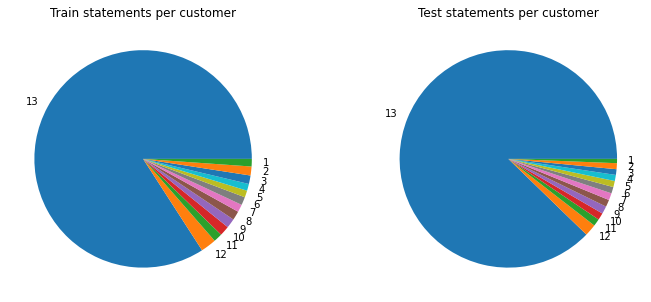

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
test_sc = test.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
ax2.pie(test_sc, labels=test_sc.index)
ax2.set_title(test_sc.name)
plt.show()

# display(train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer'))
# display(train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer'))


Let's find out when these customers got their last statement. The histogram of the last statement dates shows that every train customer got his last statement in March of 2018. The first four Saturdays (March 3, 10, 17, 24) have more statements than an average day.

The test customers are split in two: half of them got their last statement in April of 2019 and half in October of 2019. As was [discussed here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327602), the April 2019 data is used for the public leaderboard and the October 2019 data is used for the private leaderboard.

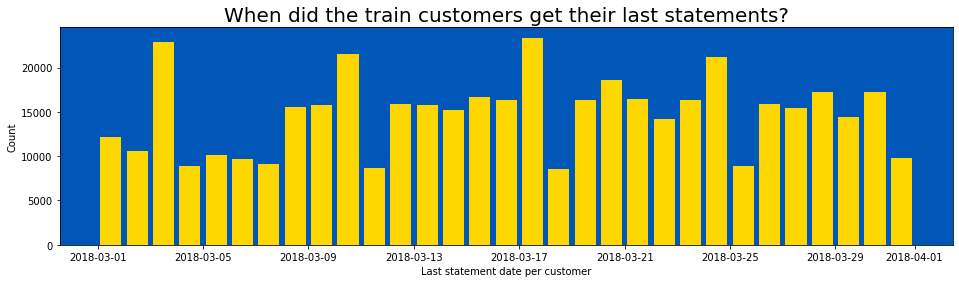

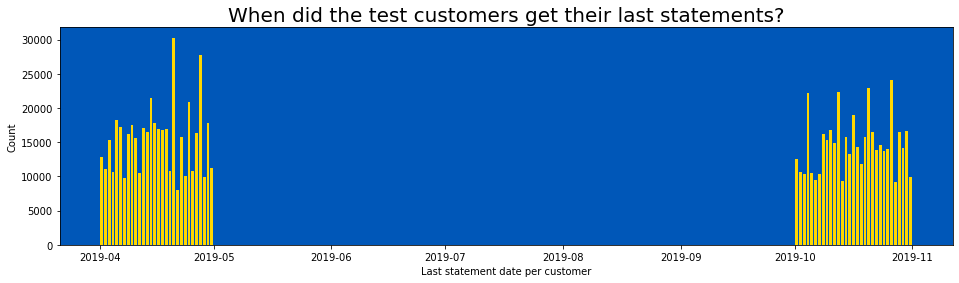

In [10]:
temp = train.S_2.groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test.S_2.groupby(test.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

**Insight:** Although the data are a kind of time series, we cannot cross-validate with a TimeSeriesSplit because all training happens in the same month.

For most customers, the first and last statement is about a year apart. Together with the fact that we typically have 13 statements per customer, this indicates that the customers get one credit card statement every month.

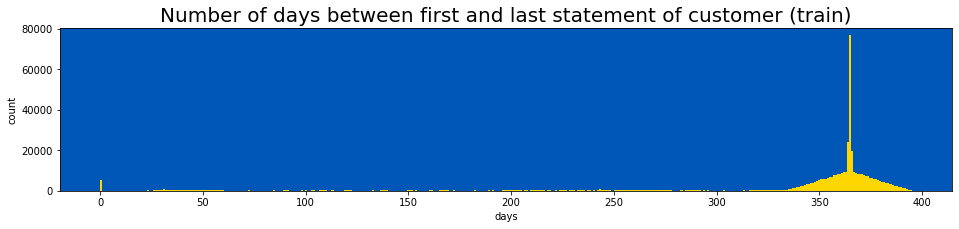

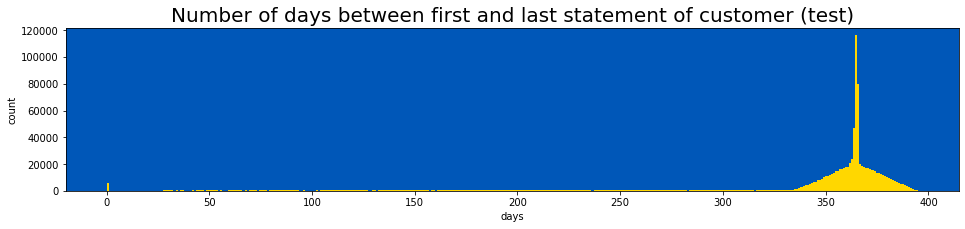

In [11]:
temp = train.S_2.groupby(train.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()

temp = test.S_2.groupby(test.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (test)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

If we color every statement (i.e. row of train or test) according to the dataset it belongs (training, public lb, and private lb), we see that every dataset covers thirteen months. Train and test don't overlap, but public and private lb periods overlap.

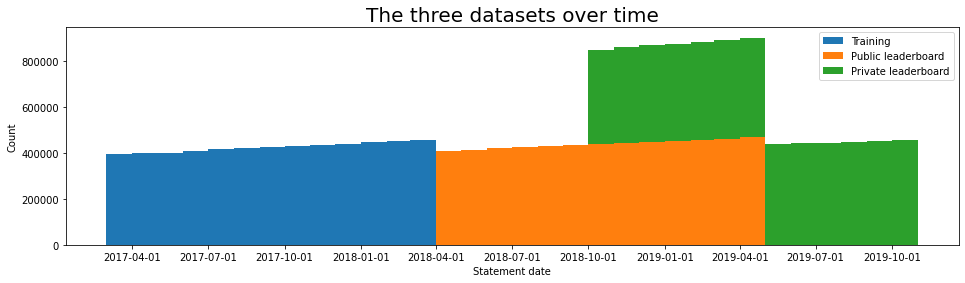

In [12]:
temp = pd.concat([train[['customer_ID', 'S_2']], test[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)
temp['last_month'] = temp.groupby('customer_ID').S_2.max().dt.month
last_month = temp['last_month'].values

plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],   # ending 03/18 -> training
          temp.S_2[temp.last_month == 4],   # ending 04/19 -> public lb
          temp.S_2[temp.last_month == 10]], # ending 10/19 -> private lb
         bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['Training', 'Public leaderboard', 'Private leaderboard'],
         stacked=True)
plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()


Now we'll look at the distribution of missing values over time. B_29 is most interesting. Given the each of the three datasets has almost half a million customers, we see that until May of 2019 fewer than a tenth of the customers have a value for B_29. The other nine tenths are missing. Starting in June of 2019, we have B_29 data for almost every customer. 

**Insight:** The distribution of the missing B_29 differs between train and test datasets. Whereas in the training and public leaderboard data >90 % are missing, during the last five months of private leaderboard, we have B_29 data for almost every customer. If we use this feature, we should be prepared for surprises in the private leaderboard. Is it better to drop the feature?

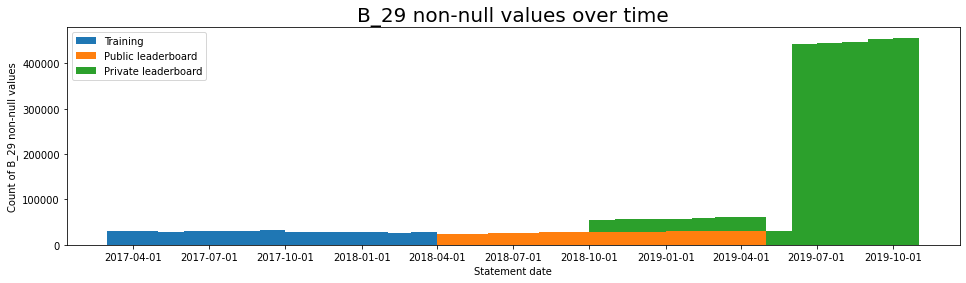

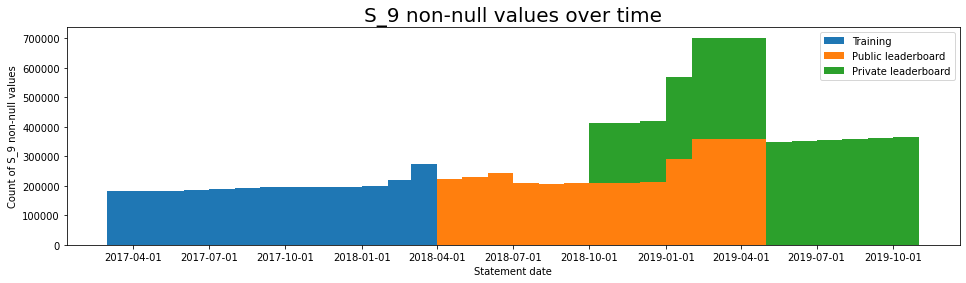

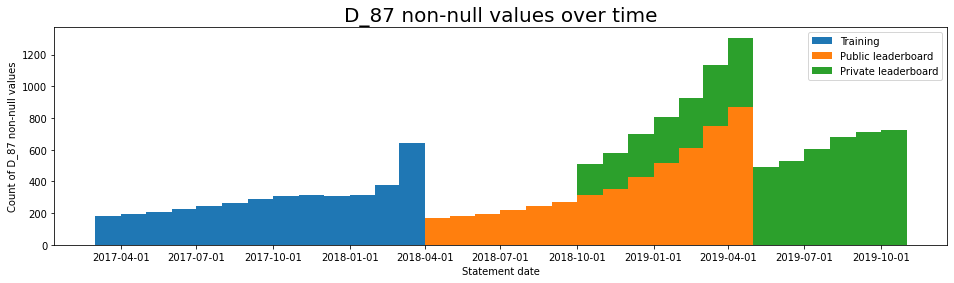

In [13]:
for f in [ 'B_29', 'S_9','D_87']:#, 'D_88', 'R_26', 'R_27', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42']:
    temp = pd.concat([train[[f, 'S_2']], test[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna() 

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
             label=['Training', 'Public leaderboard', 'Private leaderboard'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()


# The categorical features

According to the [data description](https://www.kaggle.com/competitions/amex-default-prediction/data), there are eleven categorical features. We plot histograms for target=0 and target=1. For the ten features which have missing values, the missing values are represented by the rightmost bar of the histogram.


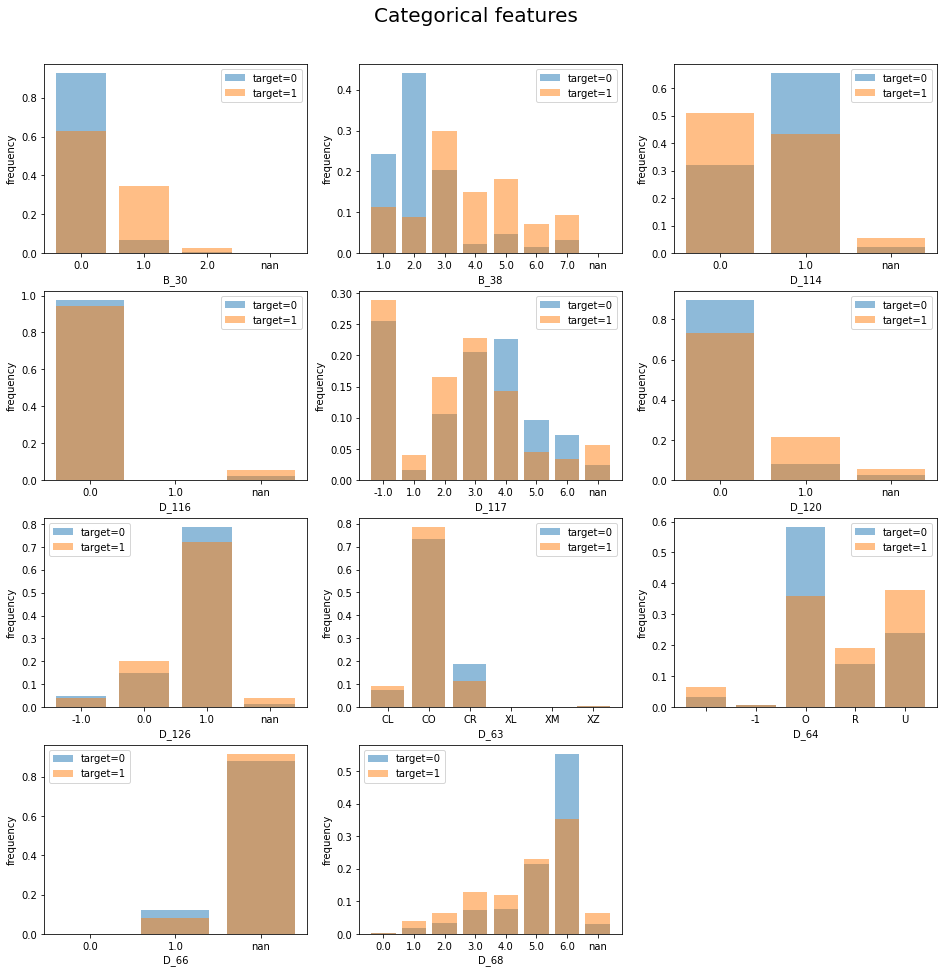

In [14]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp


**Insight:**
- Every feature has at most eight categories (including a nan category). One-hot encodings are feasible.
- The distributions for target=0 and target=1 differ. This means that every feature gives some information about the target.


# The binary features

Two features are binary:
- B_31 is always 0 or 1.
- D_87 is always 1 or missing.

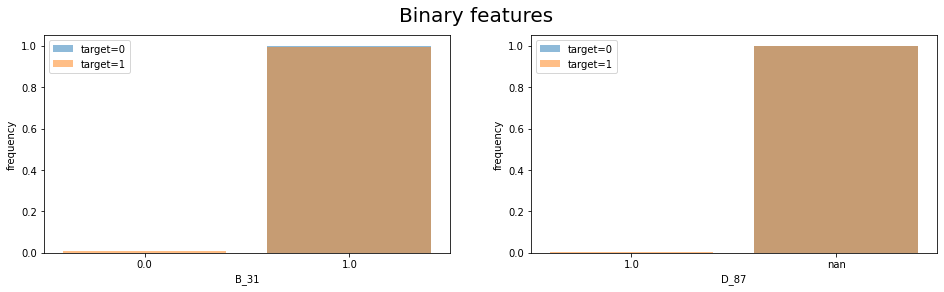

In [15]:
bin_features = ['B_31', 'D_87']
plt.figure(figsize=(16, 4))
for i, f in enumerate(bin_features):
    plt.subplot(1, 2, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Binary features', fontsize=20)
plt.show()
del temp

**Insight:** If you impute missing values for D_87, don't fall into the trap of imputing the mean - the feature would become useless...

# The numerical features

If we plot histograms of the 175 numerical features, we see that they have all kinds of distributions:

175


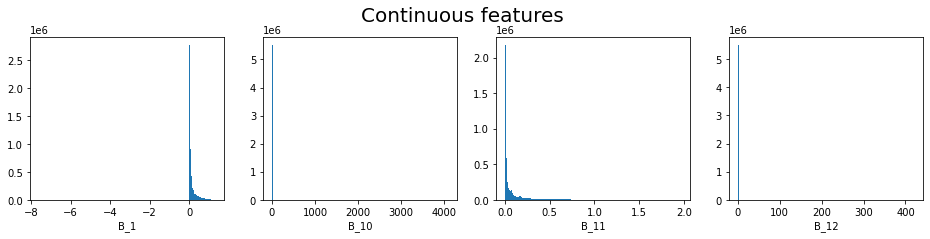

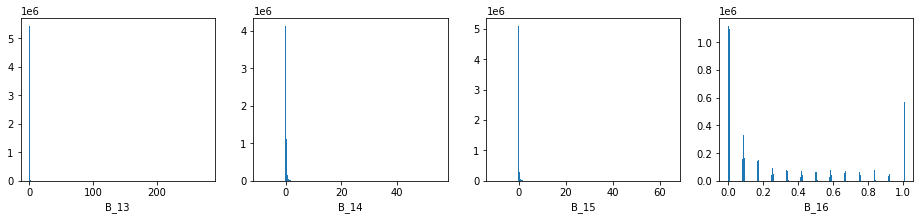

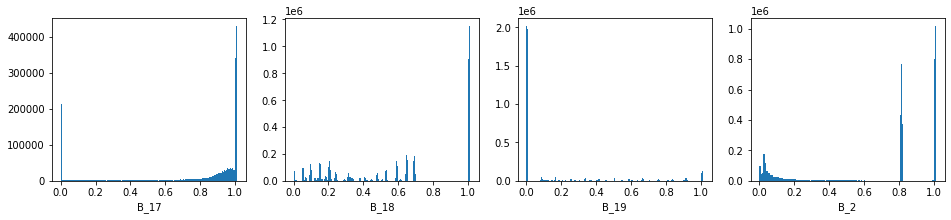

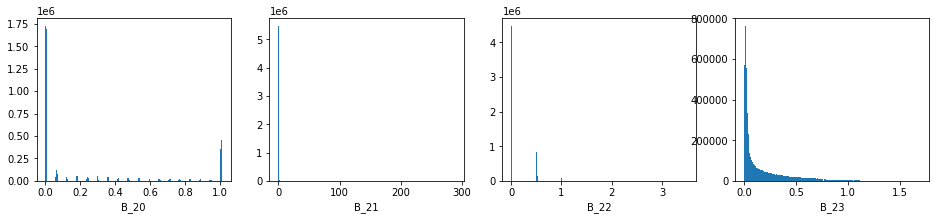

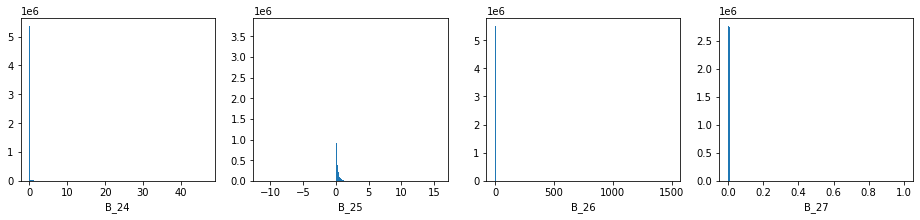

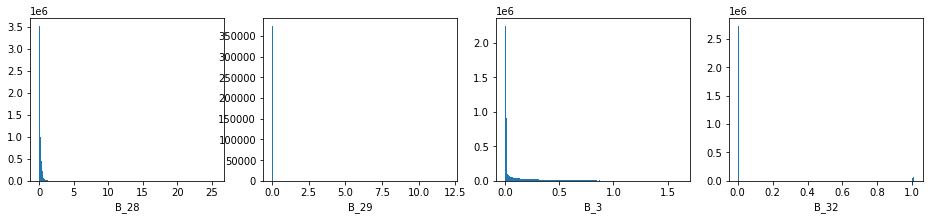

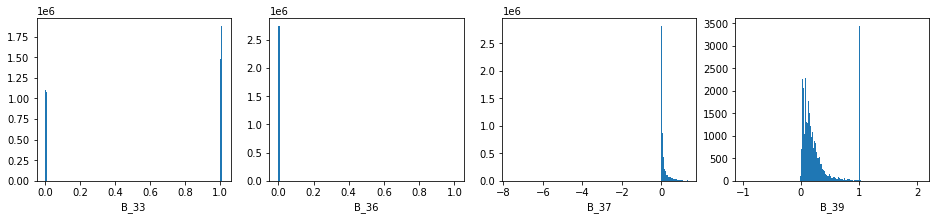

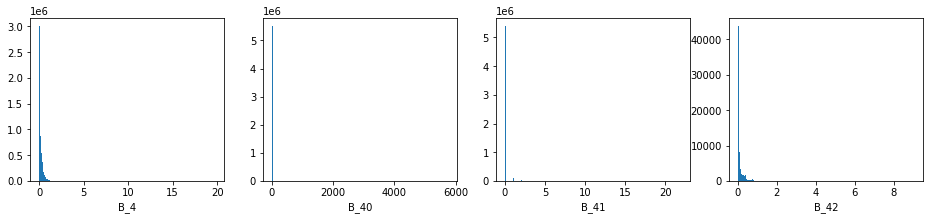

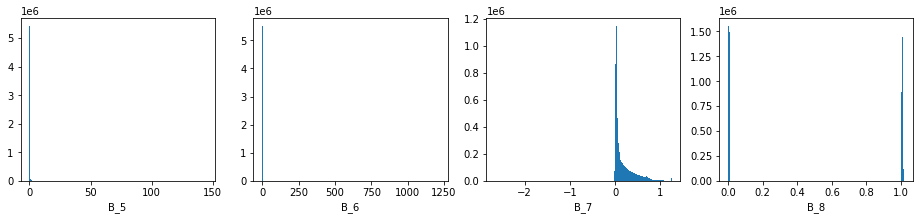

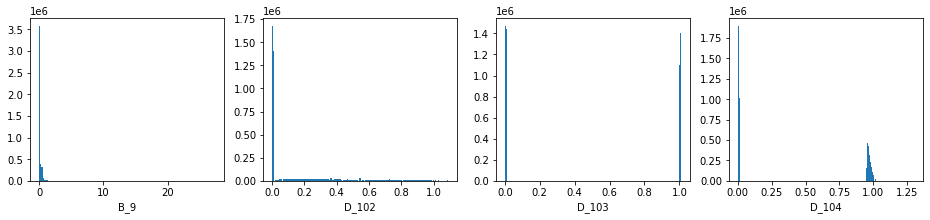

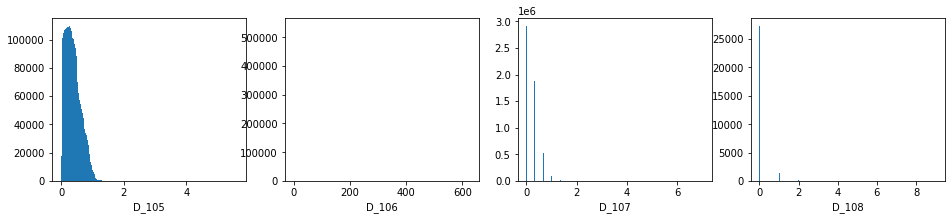

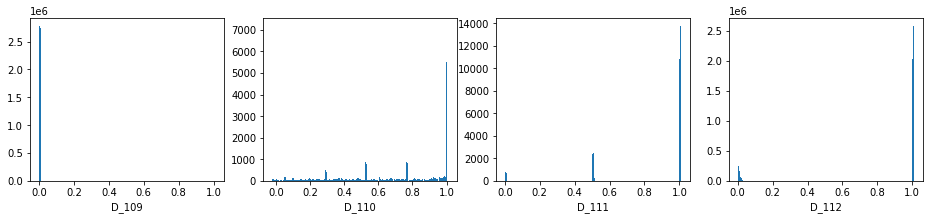

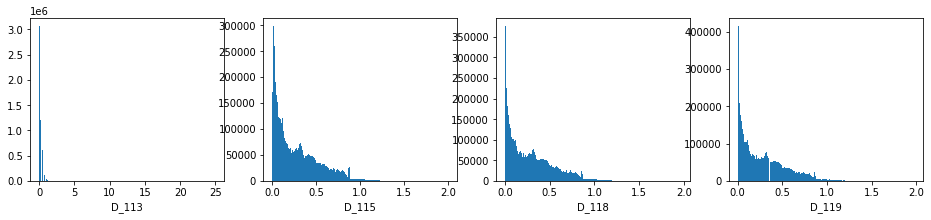

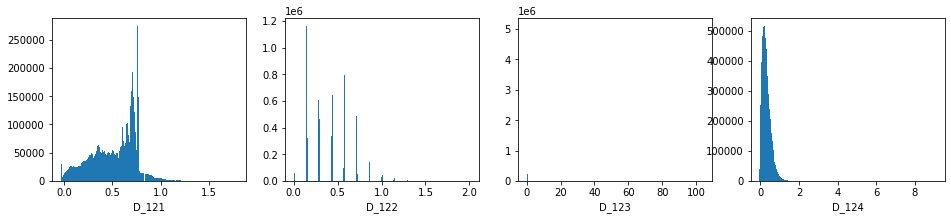

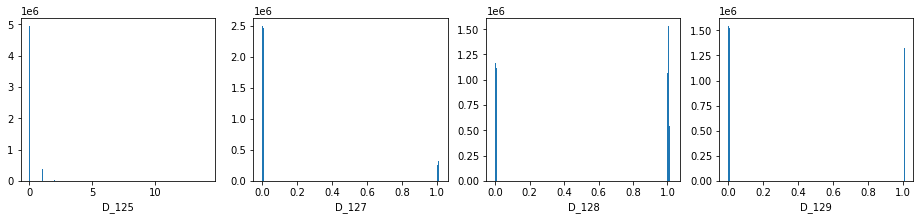

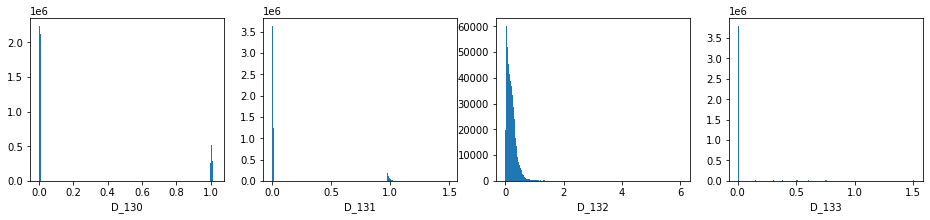

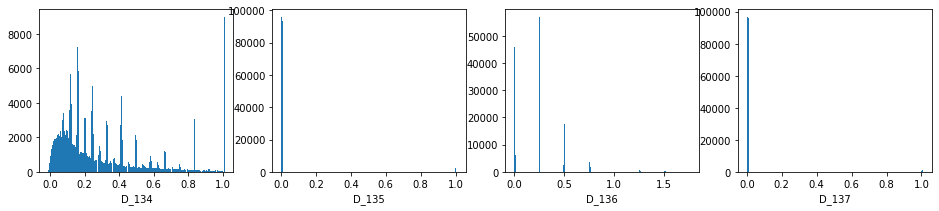

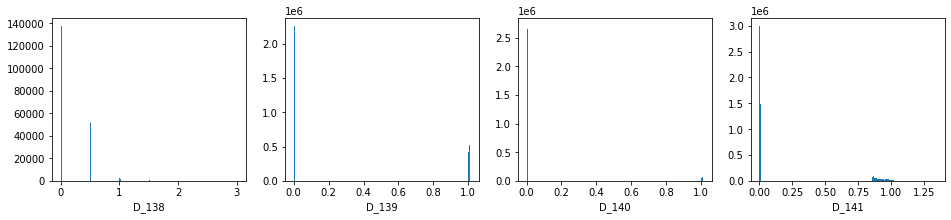

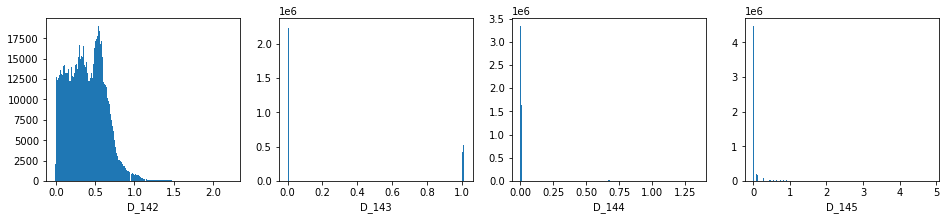

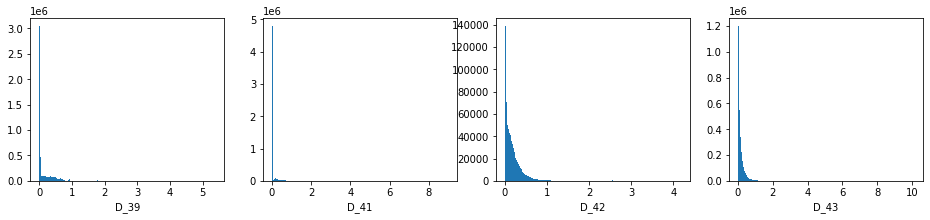

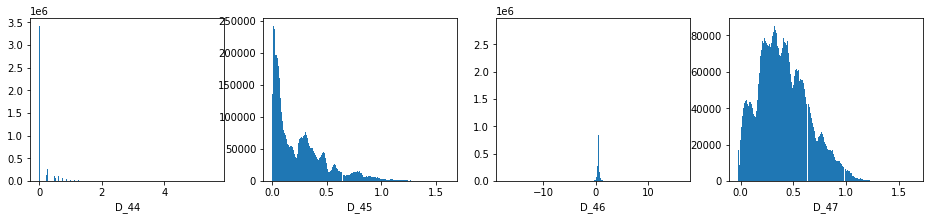

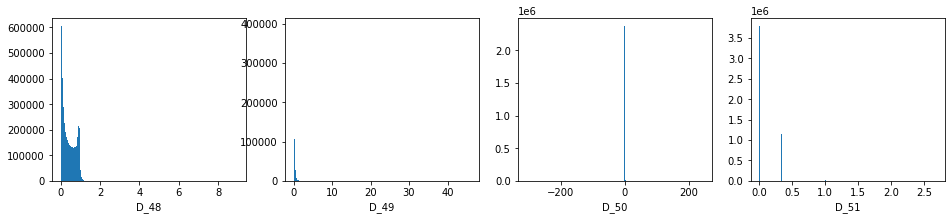

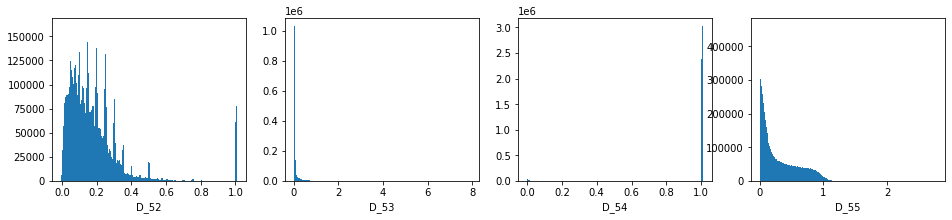

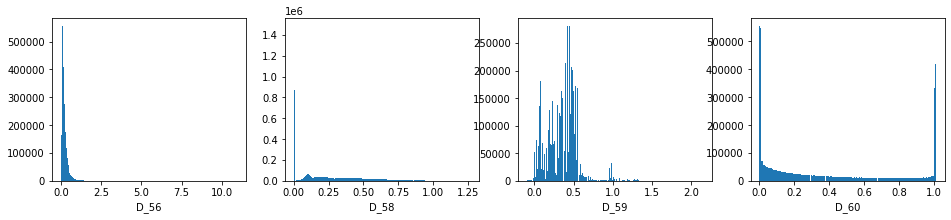

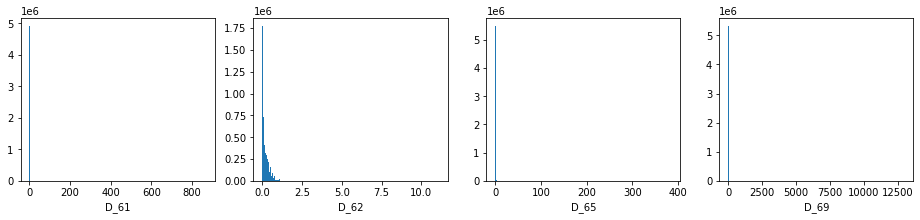

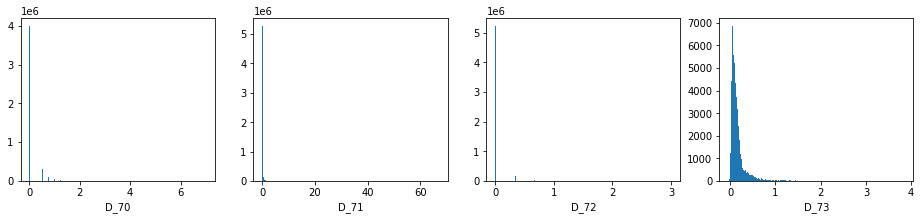

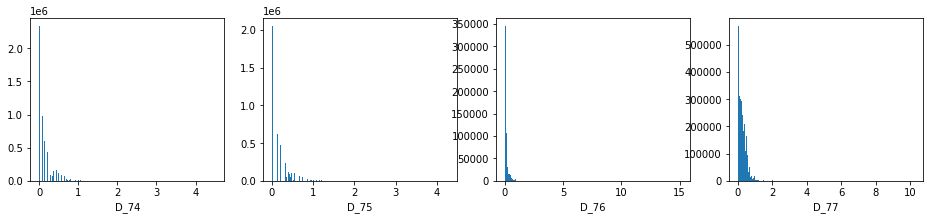

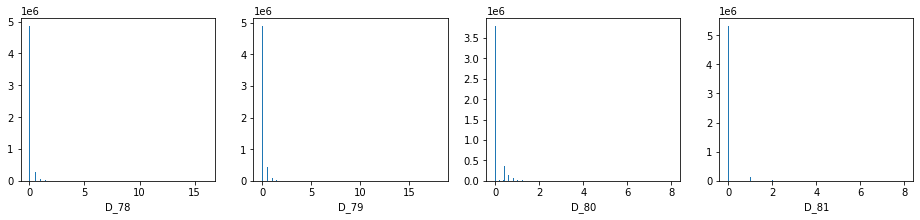

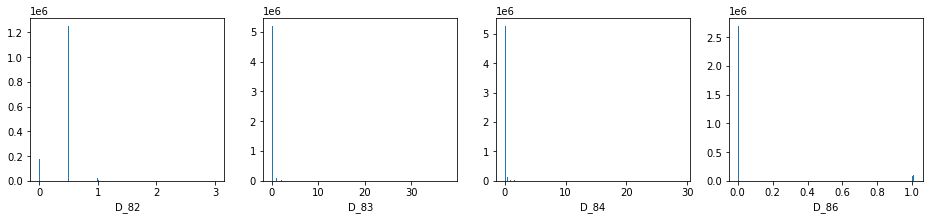

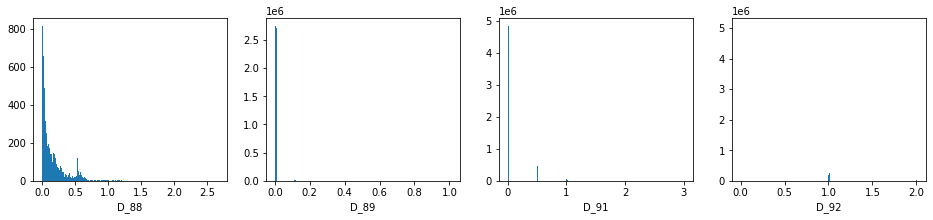

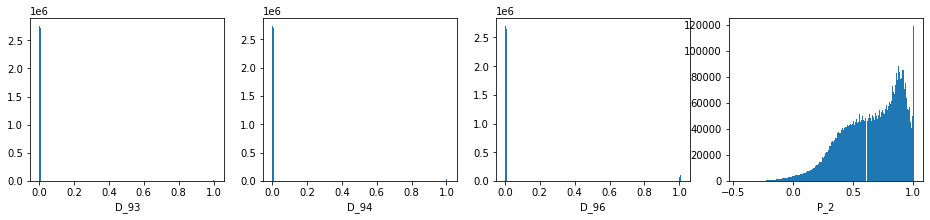

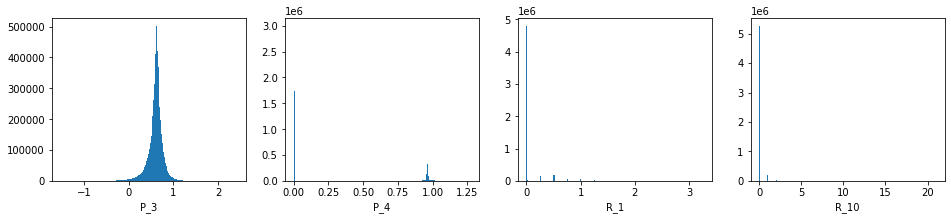

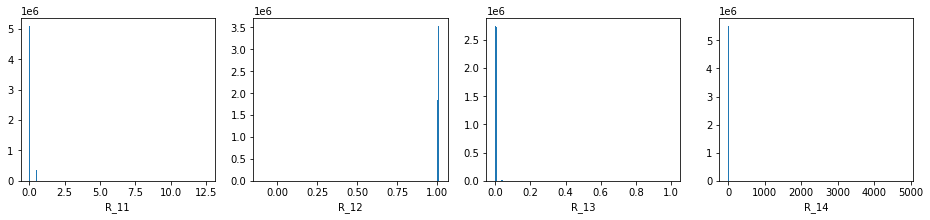

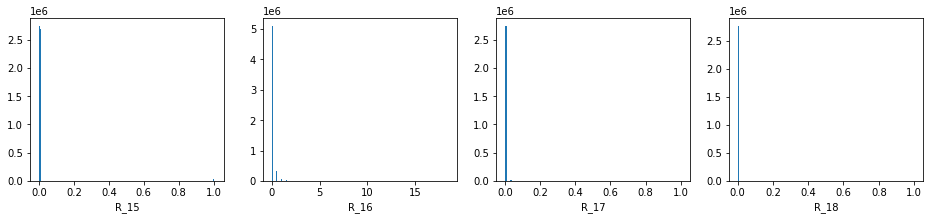

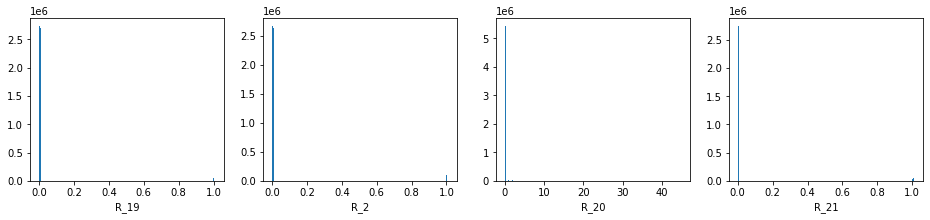

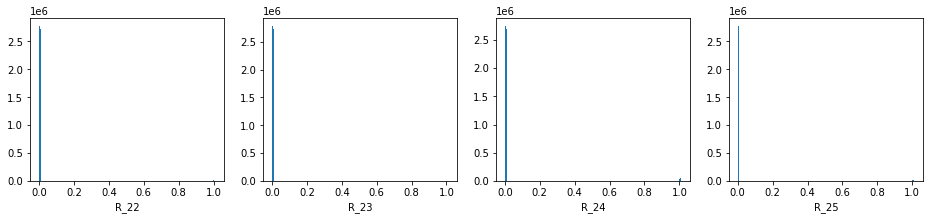

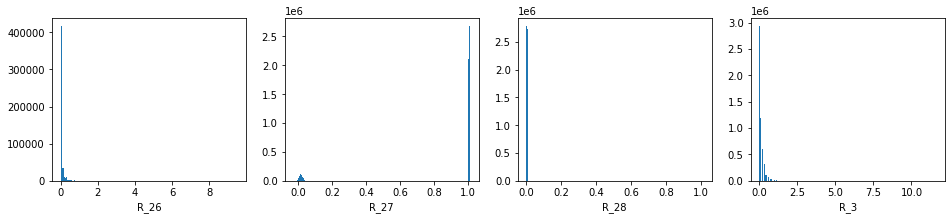

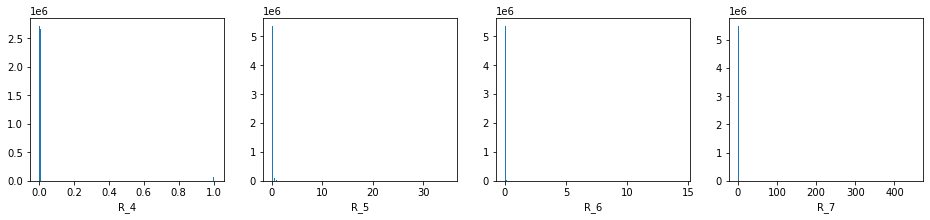

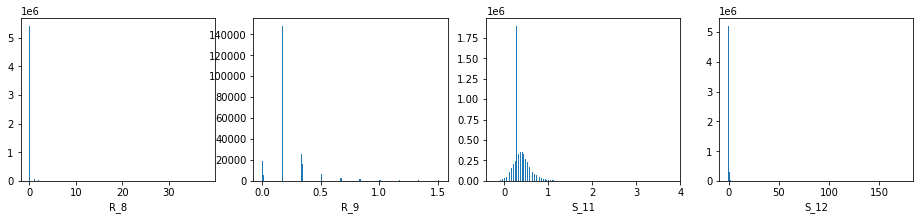

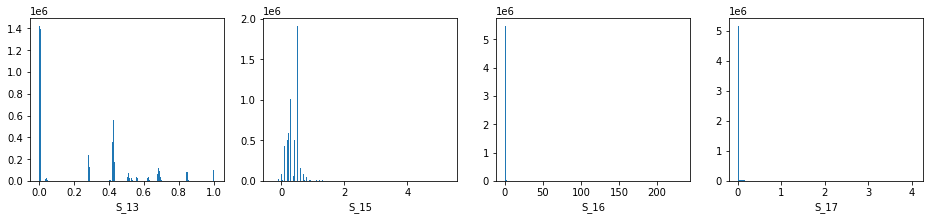

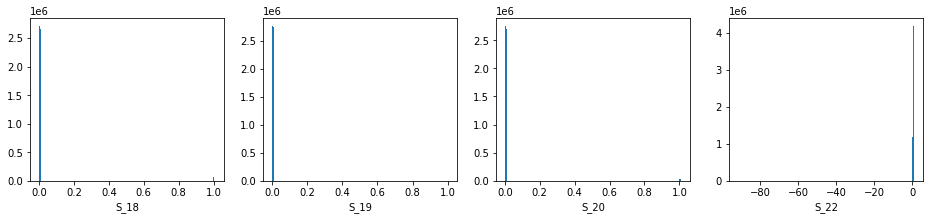

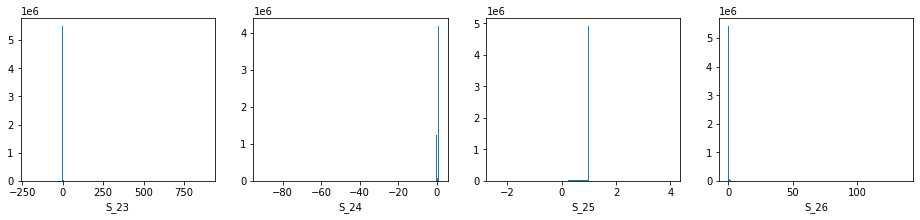

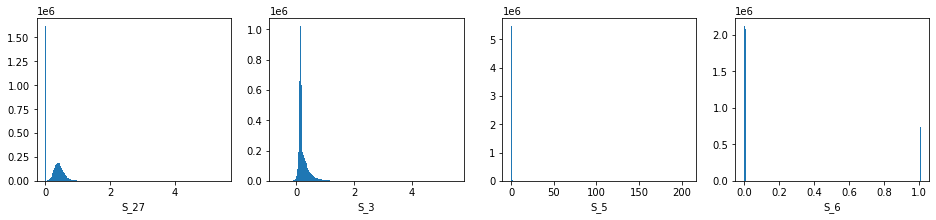

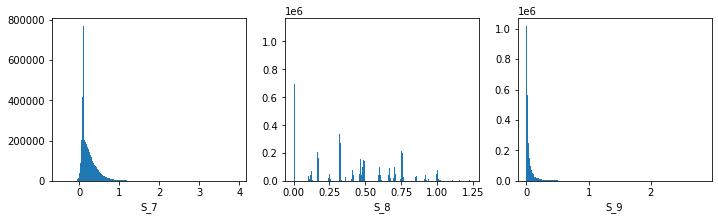

In [16]:
cont_features = sorted([f for f in train.columns if f not in cat_features + bin_features + ['customer_ID', 'target', 'S_2']])
print(len(cont_features))
# print(cont_features)
ncols = 4
for i, f in enumerate(cont_features):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(train[f], bins=200)
    plt.xlabel(f)
plt.show()

**Insight:** Histograms with white space at the left or right end can indicate that the data contain outliers. We will have to deal with these outliers. But are these data really outliers? Maybe they are, but they could as well be legitimate traces of rare events. We do not know...


# The artificial noise in the data

The data contain artificial noise. To understand the noise, we need to analyze the data at full precision. Because we cannot load the whole dataset at full precision into memory, we load only two interesting columns. For a complete analysis, see @raddar's [discussion post](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514).

In [17]:
def read_columns(name, features):
    """Read the specified columns of the train/test csv at full precision"""
    chunksize = 1000000
    chunklist = []
    with pd.read_csv(f"../input/amex-default-prediction/{name}_data.csv", chunksize=chunksize) as reader:
        for i, chunk in enumerate(reader):
            chunk = chunk[features] # keep only selected columns
            chunklist.append(chunk)
            print(i, end=' ')
            if i == 5: break
        print()
    df = pd.concat(chunklist, axis=0)
    return df

df = read_columns('train', ['B_19', 'S_13'])
df.info()

0 1 2 3 4 5 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   B_19    float64
 1   S_13    float64
dtypes: float64(2)
memory usage: 84.4 MB


Let's look at B_19. All values are between 0 and 1.01. To get a high-resolution histogram, we spread it over eleven diagrams. The histogram show only rectangles of width 0.01, which indicate that the values are uniformly distributed in intervals of width 0.01, but every interval has another probability. This means that B_19 originally had some other range, but was scaled, rounded and got added some uniform noise by applying the following function:

```
def anonymize(data):
    data -= data.min()
    data /= data.max()
    data = data.round(2)
    rng = np.random.default_rng()
    data += rng.uniform(0, 0.01, len(data))
    return data
```


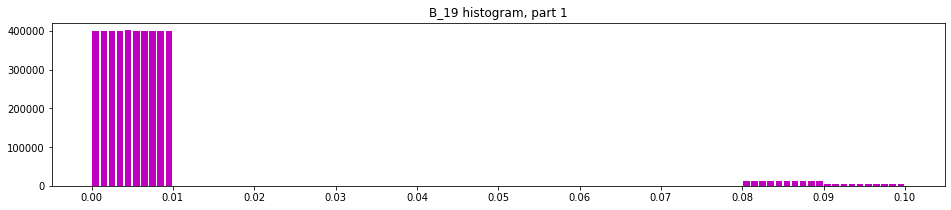

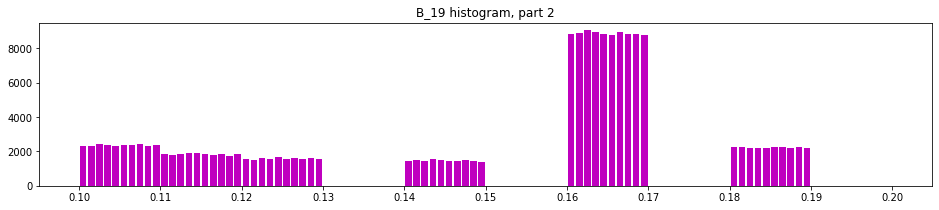

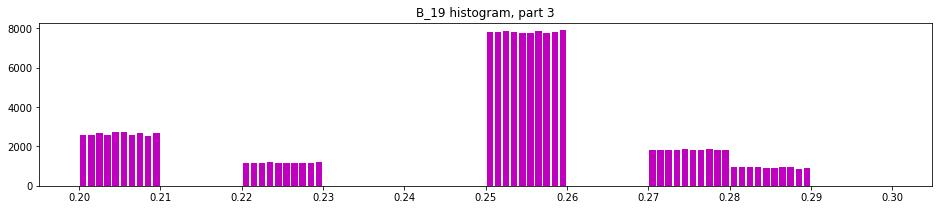

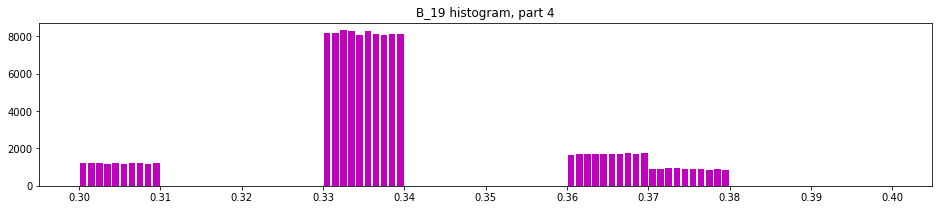

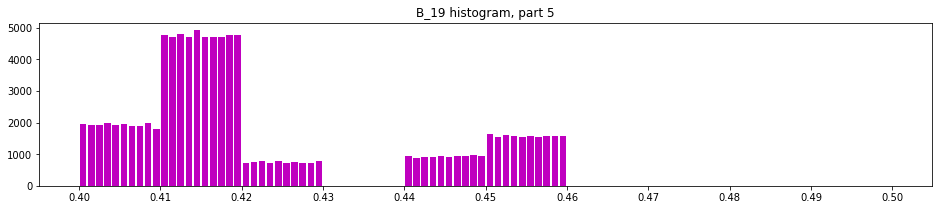

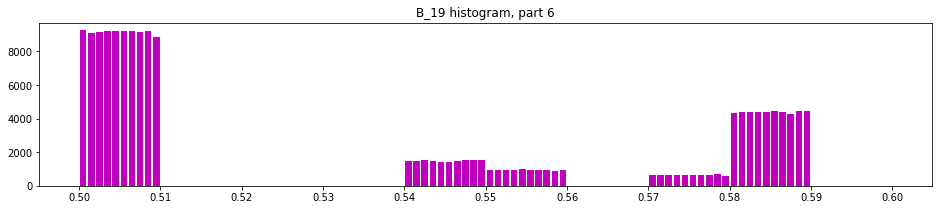

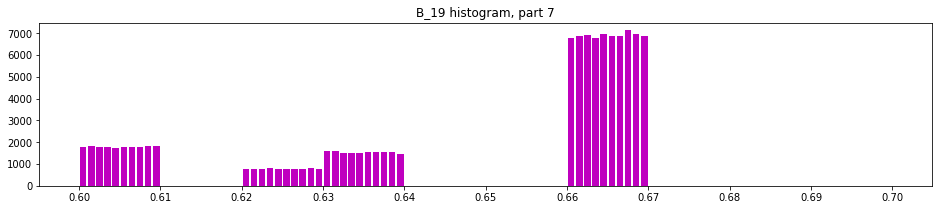

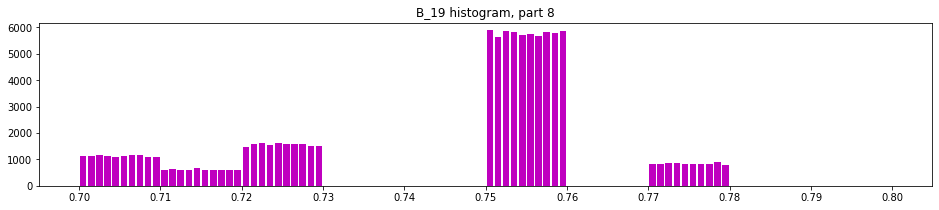

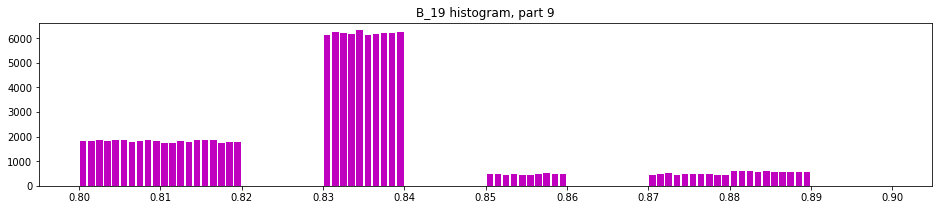

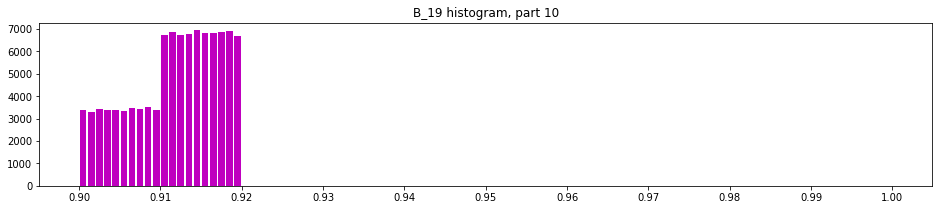

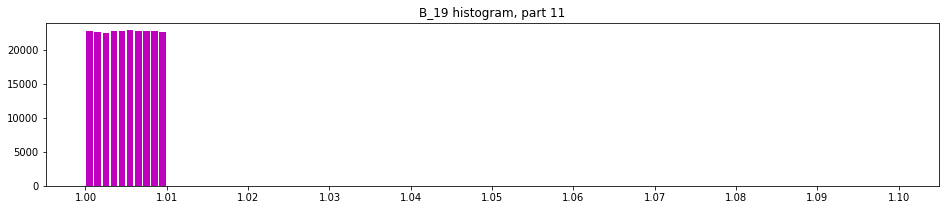

In [18]:
y = df.B_19
for i in np.linspace(0, 1, 11):
    plt.figure(figsize=(16, 3))
    plt.hist(y, bins=np.linspace(i, i+0.1, 101), rwidth=0.8, color='m')
    plt.xticks(np.linspace(i, i+0.1, 11))
    plt.title(f"B_19 histogram, part {int(i*10+1)}")
    plt.show()


**Insight:** We don't care about the scaling, we cannot do anything against the rounding, but we should remove the artificial noise, e.g. by applying a function such as `x['B_19'] = x['B_19'].apply(lambda t: np.floor(t*100))`

S_13 looks similar, the rectangles again have width 0.01, but they start at multiples of 1/1034. This means that S_13 originally had integer values in the range 0..1034 and was treated with
```
def anonymize(data):
    data -= data.min()
    data /= data.max() # divides by 1034
    rng = np.random.default_rng()
    data += rng.uniform(0, 0.01, len(data))
    return data
```
Unfortunately some rectangles overlap (e.g. between 0.68 and 0.7) so that we cannot remove the noise.

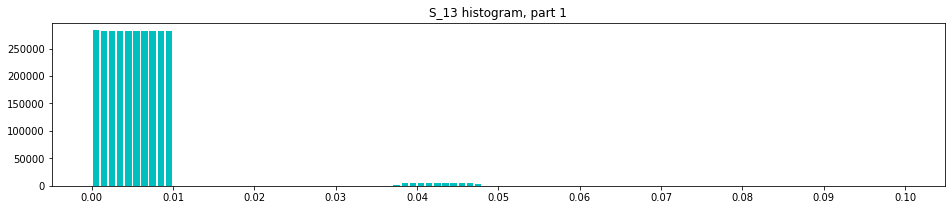

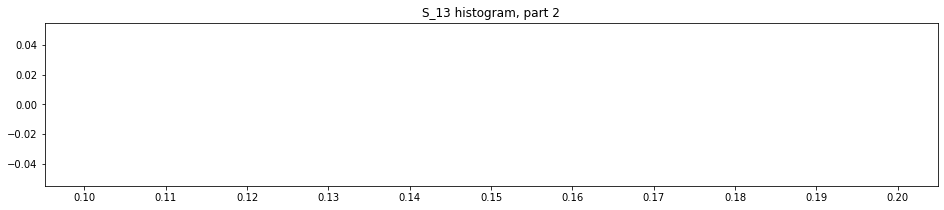

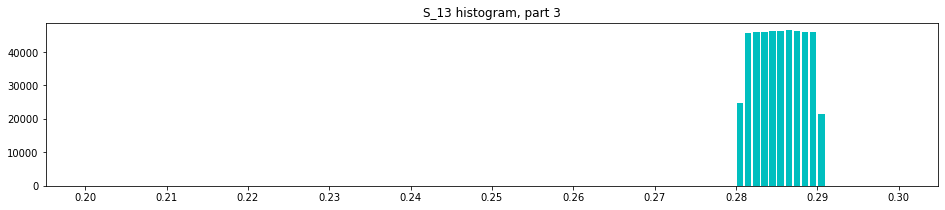

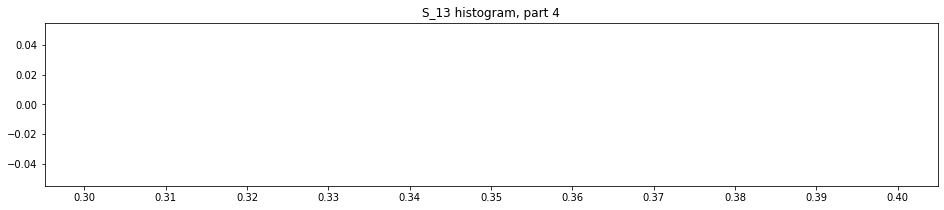

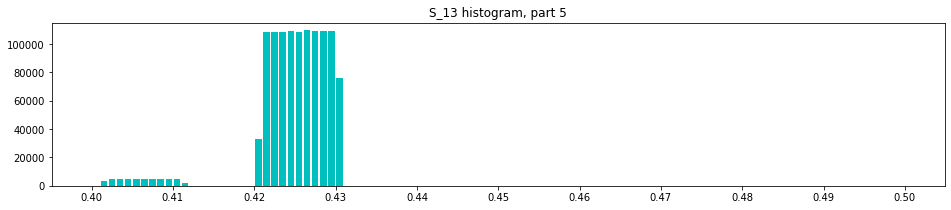

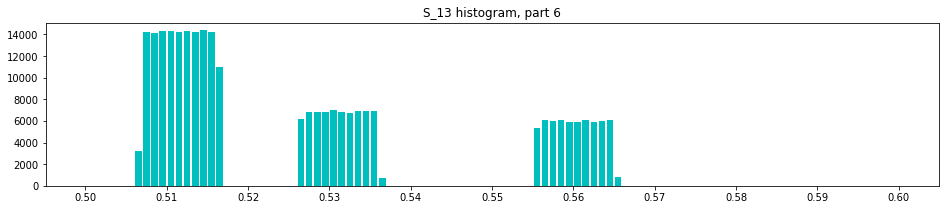

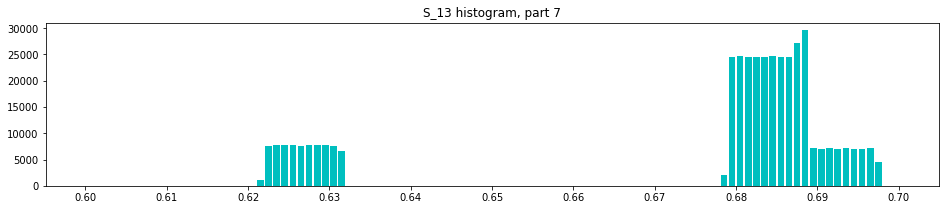

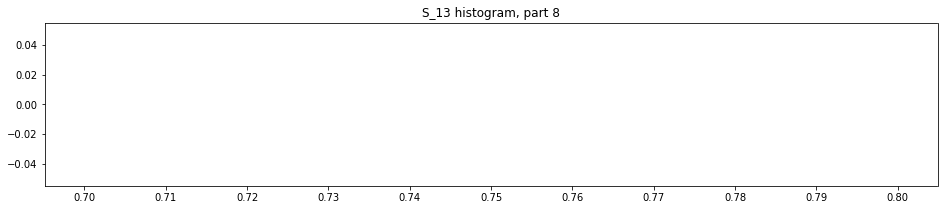

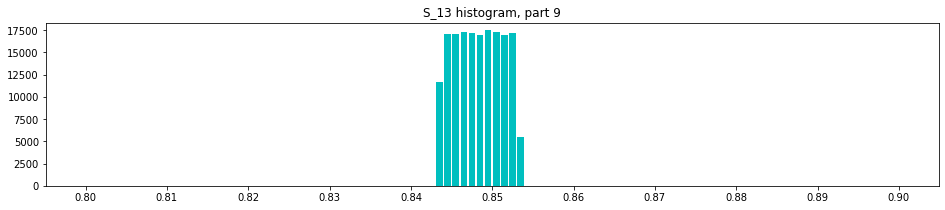

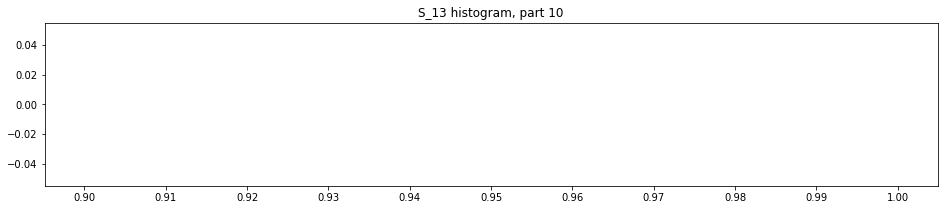

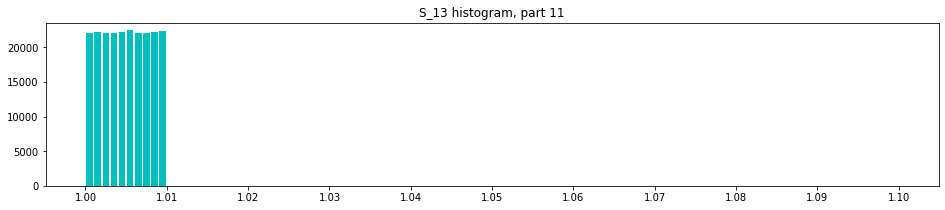

In [19]:
y = df.S_13
for i in np.linspace(0, 1, 11):
    plt.figure(figsize=(16, 3))
    plt.hist(y, bins=np.linspace(i, i+0.1, 101), rwidth=0.8, color='c')
    plt.xticks(np.linspace(i, i+0.1, 11))
    plt.title(f"S_13 histogram, part {int(i*10+1)}")
    plt.show()